# Simulating myosin cluster growth
In this Jupyter notebook, I constructed a simple toy model to simulate the growth of myosin clusters. 

Myosin cluster growth is simulated as a Monte-Carlo process. To initialize the simulation, we prescribe the number of myosin that is available for cluster growth ($N_{myo}$, or `numMyosin`).

Each myosin can randomly bind to a 1D grid of size `numGrid`. Each grid is initialized with an initial myosin cluster size based on experimental conditions.

In each iteration, a single myosin binds randomly on a grid based on a given probability $P_i=\frac{1+{\alpha}M_i}{{\sum_i}P_i}$. $\alpha$ is an affinity parameter that captures the scenario where myosin preferrentially binds to existing myosin clusters.

After iterating through all available myosins, the final myosin cluster size distribution is compared with the experimentally determined myosin cluster sizes.

![SimSetup](FigSIM_A.png "Simulation setup")

In [6]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from random import choices
import seaborn as sns
import random
from numpy.random import default_rng
import pandas as pd

### Setting up the simulation

In [7]:
### Define convenience functions
def randFromECDF(dp, ecdf, n):
    ## Draw n random numbers from empirical CDF
    randNum = np.zeros((n))
    rng = default_rng(seed=1234)
    for ii in range(n):
        u = rng.uniform()
        idx = np.argmin(ecdf<=u)
        randNum[ii] = (dp[idx]+dp[min(idx+1, len(ecdf)-1)])/2
    
    return randNum

def ecdf(a):
    ## Calculate empirical CDF
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def plot_ecdf(a, label, line, color):
    ## Plot empirical CDF
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    plt.plot(x, y, drawstyle='steps-post', alpha = 0.5, linestyle = line, color = color, label = label)
    plt.grid(True)

def cdf_dist(data1, data2):
    ## Calculate average distance between two CDFs
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    data_all = np.concatenate([data1, data2])
    cdf_sim = np.searchsorted(data1, data_all, side='right') / data1.shape[0]
    cdf_exp = np.searchsorted(data2, data_all, side='right') / data2.shape[0]
    cddiffs = cdf_exp - cdf_sim
    dist = np.sum(np.abs(cddiffs)) / data_all.shape[0]

    return dist

In [15]:
# Define function that runs simulation based on weights that are defined
def runSimulation(numGrid, numMyosin, MyosinInit, myosinBiasVal):
    ### numGrid: number of grid points
    ### numMyosin: number of new myosin filaments to bind
    ### MyosinInit: initial myosin cluster size
    ### MyosinBiasVal: affinity parameter for myosin self-affinity

    MyosinNum = MyosinInit.copy()

    random.seed(42)    # Reproducibility
    # Define probability weights and draw random grid number that myosin lands
    for ii in range(numMyosin):
        index = np.arange(0, numGrid)
        myosinBias = MyosinNum * myosinBiasVal
        weights = np.ones((numGrid)) + myosinBias
        weights = weights/np.sum(weights)

        landing = choices(index, weights)
        MyosinNum[landing] = MyosinNum[landing] + 1

    
    return MyosinNum

In [9]:
### Read data
allPointDataYB = pd.read_csv('allPointData_YB.csv', names = ['labels', 'intensity'])
allPointDataYoutB = pd.read_csv('allPointData_YoutB.csv', names = ['labels', 'intensity'])
allPointDataBB = pd.read_csv('allPointData_BB.csv', names = ['labels', 'intensity'])
allPointDataWT = pd.read_csv('allPointData_WT.csv', names = ['labels', 'intensity'])

allPointDataYB['normInt'] = allPointDataYB['intensity']/allPointDataYB['intensity'].min()
allPointDataYoutB['normInt'] = allPointDataYoutB['intensity']/allPointDataYoutB['intensity'].min()
allPointDataBB['normInt'] = allPointDataBB['intensity']/allPointDataBB['intensity'].min()
allPointDataWT['normInt'] = allPointDataWT['intensity']/allPointDataWT['intensity'].min()


## Myosin cluster growth without myosin motor activity (Blebbistatin $\pm$ Y-27)

### Visualize initial myosin cluster sizes

In [10]:
# Load experimental data
allPointDataYB.head()

,labels,intensity,normInt
0,1,3539.076496,3.916921
1,1,4665.344665,5.163434
2,1,5115.054538,5.661156
3,1,2523.869688,2.793327
4,1,1988.137071,2.200398


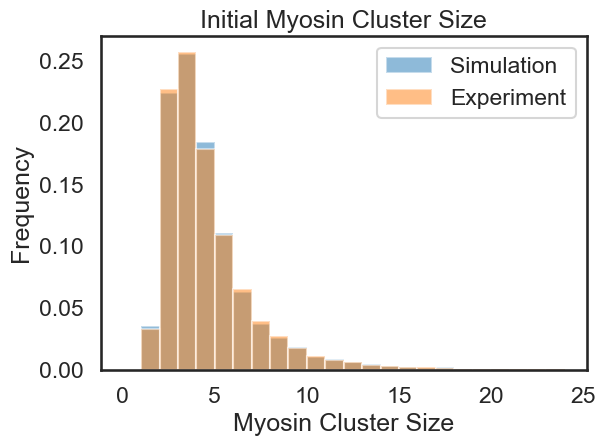

In [11]:
#lognormNum1 = GenMyoNum('lognormal', 10000, 1.31, 0.52)
x, cdf_YB = ecdf(allPointDataYB['normInt'])
MyosinInit = randFromECDF(x, cdf_YB, 10000)
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(MyosinInit, bins = np.arange(25), density = True, alpha = 0.5, label = 'Simulation')
plt.hist(allPointDataYB['normInt'], bins = np.arange(25), density = True, alpha = 0.5, label = 'Experiment')
plt.title('Initial Myosin Cluster Size')
plt.legend()
plt.xlabel('Myosin Cluster Size')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.show()
#plt.savefig('Initial cluster size.png')

In [12]:
print(np.sum(MyosinInit))

47356.28900301577


### Myosin cluster growth with or without myosin self-affinity ($\alpha$=0 or $\alpha$>0)

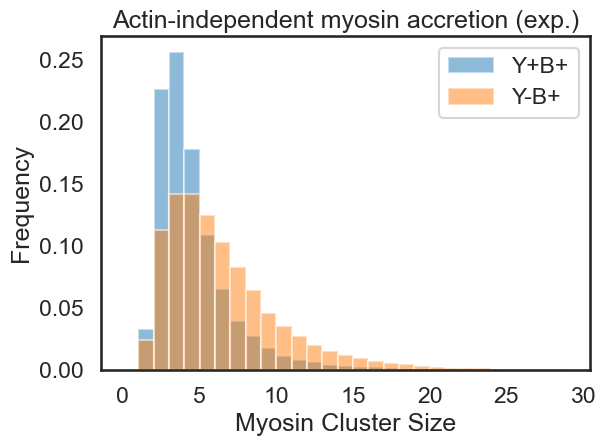

In [13]:
# Visualize experimental results: myosin cluster sizes in Y+B+ versus Y-B+
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(allPointDataYB['normInt'], bins = np.arange(30), alpha=0.5, density=True, label='Y+B+')
plt.hist(allPointDataYoutB['normInt'], bins = np.arange(30), alpha=0.5, density = True, label='Y-B+')
plt.title('Actin-independent myosin accretion (exp.)')
plt.legend()
plt.xlabel('Myosin Cluster Size')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.show()
#plt.savefig('YoutB.png', transparent = True)

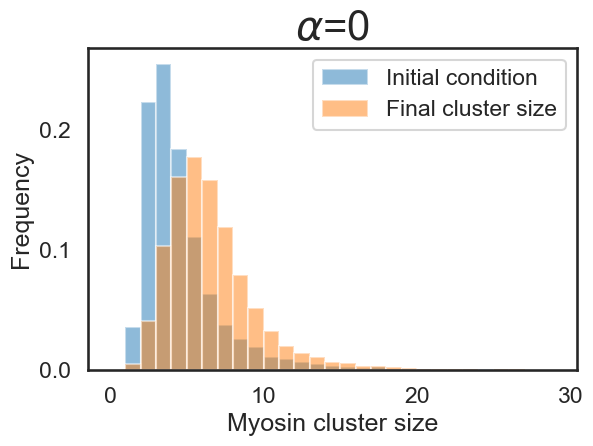

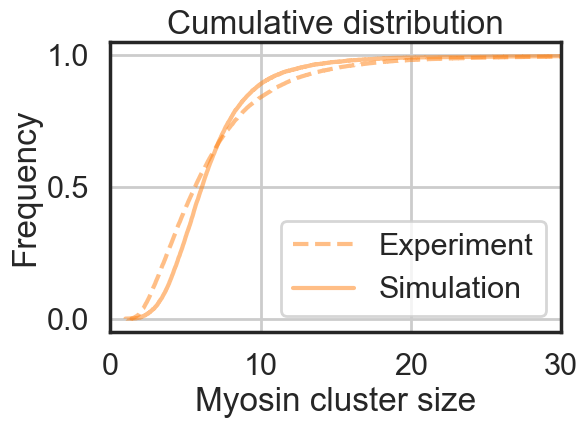

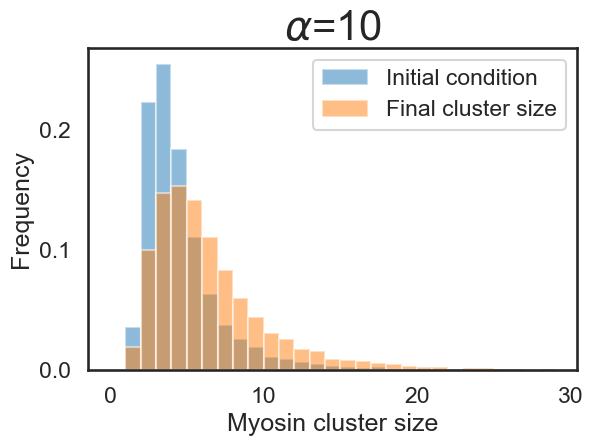

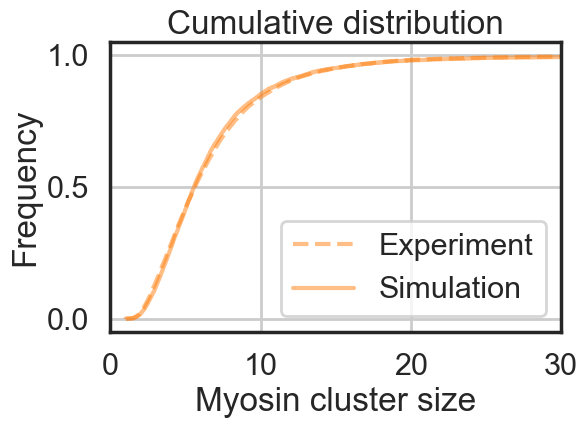

In [16]:
numGrid = 10000
x, cdf_YB = ecdf(allPointDataYB['normInt'])
MyosinInit = randFromECDF(x, cdf_YB, numGrid)
numMyosin = [int(np.sum(MyosinInit)*0.42)]        ## Iterate through numMyosin if needed
myosinBiasVal = [0, 10]


# Initialize and run simulation
for ii in range(len(numMyosin)):
    for jj in range(len(myosinBiasVal)):
        
        res = runSimulation(numGrid, numMyosin[ii], MyosinInit, myosinBiasVal[jj])

        co = sns.color_palette()
        # Save histogram
        plt.figure()
        sns.set_style("white")
        sns.set_context("talk")
        xfit = np.arange(0, 30, 0.2)
        plt.hist(MyosinInit, bins = np.arange(30), alpha=0.5, color = co[0], density = True, label = 'Initial condition')
        plt.hist(res, bins = np.arange(30), alpha=0.5, color = co[1], density = True, label = 'Final cluster size')
        #plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
        plt.xlabel("Myosin cluster size")
        plt.ylabel("Frequency")
        plt.title(r'$\alpha$='+str(myosinBiasVal[jj]), fontsize = 30)
        plt.legend()
        plt.tight_layout()
        #plt.savefig('myosinBinding_histogram_numGrid10000_numMyosin_'+str(numMyosin[ii])+'_myoBias_'+str(myosinBiasVal[jj])+'_acBias_0.png', dpi = 300, transparent = True)

        # Save CDF
        plt.figure()
        sns.set_style("white")
        sns.set_context("poster")
        plot_ecdf(allPointDataYoutB['normInt'], 'Experiment', '--', co[1])
        plot_ecdf(res, 'Simulation', '-', co[1])
        plt.title('Cumulative distribution')
        plt.xlabel("Myosin cluster size")
        plt.ylabel("Frequency")
        plt.legend()
        plt.xlim([0, 30])
        plt.tight_layout()
        #plt.savefig('myosinBinding_ecdf_numGrid10000_numMyosin_'+str(numMyosin[ii])+'_myoBias_'+str(myosinBiasVal[jj])+'_acBias_0.png', dpi = 300, transparent = True)



### Dependence of simulated results on choice of $\alpha$

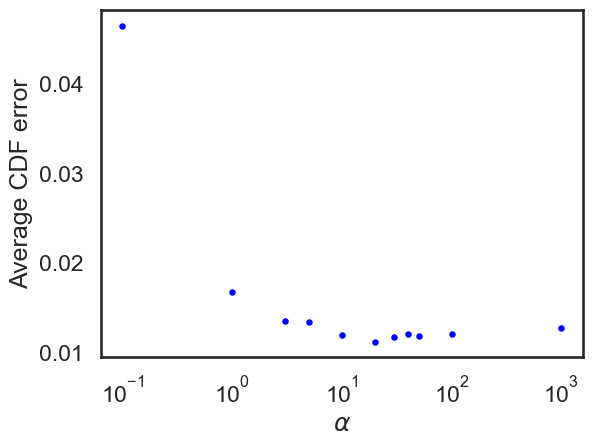

In [17]:
numGrid = 10000
x, cdf_YB = ecdf(allPointDataYB['normInt'])
MyosinInit = randFromECDF(x, cdf_YB, numGrid)
numMyosin = int(np.sum(MyosinInit)*0.42)
myosinBiasVal = [0.1, 1, 3, 5, 10, 20, 30, 40, 50, 100, 1000]

dist_arr = np.zeros((len(myosinBiasVal)))

for ii in range(len(myosinBiasVal)):
    res = runSimulation(numGrid, numMyosin, MyosinInit, myosinBiasVal[ii])
    #test = st.ks_2samp(res, allIntYoutB[allIntYoutB<=np.max(res)])

    dist_arr[ii] = cdf_dist(res, allPointDataYoutB['normInt'])

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.scatter(myosinBiasVal, dist_arr, 10, 'blue')
plt.xscale("log")
plt.xlabel(r"$\alpha$")
plt.ylabel("Average CDF error")
plt.tight_layout()
#plt.savefig("Ywashout_alpha scan.png", dpi = 300, transparent = True)

### Dependence of simulated results on the pool of myosin available for cluster growth

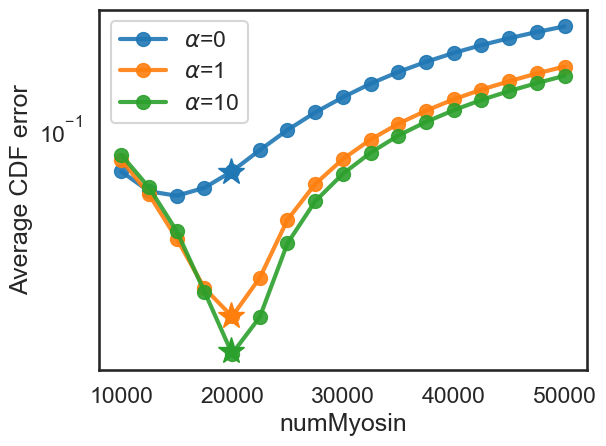

In [18]:
numGrid = 10000
x, cdf_YB = ecdf(allPointDataYB['normInt'])
MyosinInit = randFromECDF(x, cdf_YB, numGrid)
numMyosin = [10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000]
numMyosin_exp = int(np.sum(MyosinInit)*0.42)
myosinBiasVal = [0, 1, 10]

dist_arr = np.zeros((len(myosinBiasVal), len(numMyosin)))
sns.set_style("white")
sns.set_context("talk")
plt.figure()
co = sns.color_palette("tab10")

for ii in range(len(myosinBiasVal)):
    for jj in range(len(numMyosin)):
        res = runSimulation(numGrid, numMyosin[jj], MyosinInit, myosinBiasVal[ii])
        #test = st.ks_2samp(res, allIntYoutB[allIntYoutB<=np.max(res)])

        dist_arr[ii,jj] = cdf_dist(res, allPointDataYoutB['normInt'])
    plt.plot(numMyosin, dist_arr[ii,:], linewidth = 3, marker = '.', markersize = 20, color = co[ii], alpha = .9, label = r"$\alpha$="+str(myosinBiasVal[ii]))

    res_exp = runSimulation(numGrid, numMyosin_exp, MyosinInit, myosinBiasVal[ii])
    dist_exp = cdf_dist(res_exp, allPointDataYoutB['normInt'])
    plt.plot(numMyosin_exp, dist_exp, marker = '*', markersize = 20, color = co[ii], alpha = 1, label = '')

plt.yscale('log')
plt.xlabel("numMyosin")
plt.ylabel("Average CDF error")
plt.legend()
plt.tight_layout()
#plt.savefig("Ywashout_alpha scan.png", dpi = 300, transparent = True)
np.savetxt('YBout_ParamScan_CDFerror.csv', dist_arr, delimiter=',')

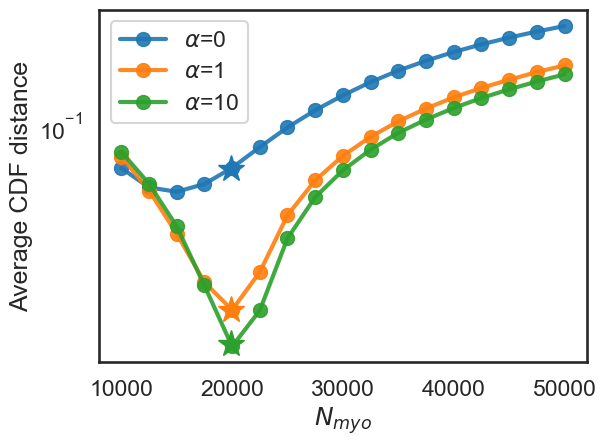

In [5]:
######## Use this if the simulated results have been saved!! ###########
### Plot CDF distance as a function of alpha and numMyosin from saved data
dist_arr = np.loadtxt('YBout_ParamScan_CDFerror.csv', delimiter=',')
numGrid = 10000
x, cdf_YB = ecdf(allPointDataYB['normInt'])
MyosinInit = randFromECDF(x, cdf_YB, numGrid)
numMyosin = [10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000]
numMyosin_exp = int(np.sum(MyosinInit)*0.42)
myosinBiasVal = [0, 1, 10]

sns.set_style("white")
sns.set_context("talk")
plt.figure()
co = sns.color_palette("tab10")
for ii in range(len(myosinBiasVal)):
    plt.plot(numMyosin, dist_arr[ii,:], linewidth = 3, marker = '.', markersize = 20, color = co[ii], alpha = .9, label = r"$\alpha$="+str(myosinBiasVal[ii]))

    res_exp = runSimulation(numGrid, numMyosin_exp, MyosinInit, myosinBiasVal[ii])
    dist_exp = cdf_dist(res_exp, allPointDataYoutB['normInt'])
    plt.plot(numMyosin_exp, dist_exp, marker = '*', markersize = 20, color = co[ii], alpha = 1, label = '')

plt.yscale('log')
plt.xlabel(r"$N_{myo}$")
plt.ylabel("Average CDF distance")
plt.legend()
plt.tight_layout()
plt.savefig("Ywashout_numMyosin_alpha scan.png", dpi = 300, transparent = True)

## Myosin cluster growth with myosin motor activity (Bleb vs Ctrl)

### Visualize initial myosin cluster size

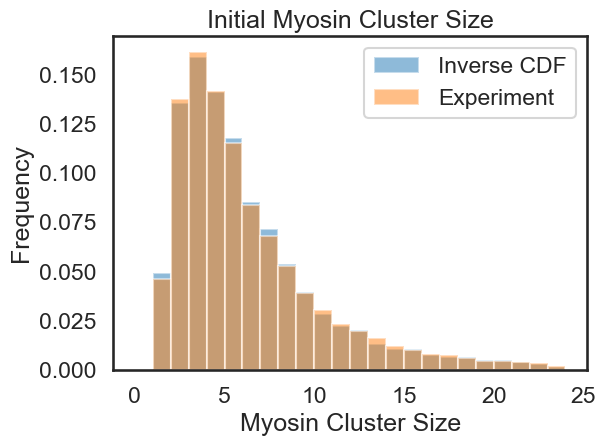

In [17]:
x, BB_cdf = ecdf(allPointDataBB['normInt'])
MyosinInit = randFromECDF(x, BB_cdf, 10000)

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(MyosinInit, bins = np.arange(25), density = True, alpha = 0.5, label = 'Simulation')
plt.hist(allPointDataBB['normInt'], bins = np.arange(25), density = True, alpha = 0.5, label = 'Experiment')
plt.title('Initial Myosin Cluster Size')
plt.legend()
plt.xlabel('Myosin Cluster Size')
plt.ylabel('Frequency')
plt.tight_layout()


### Myosin cluster growth with or without myosin self-affinity ($\alpha$=0 or $\alpha$>0)

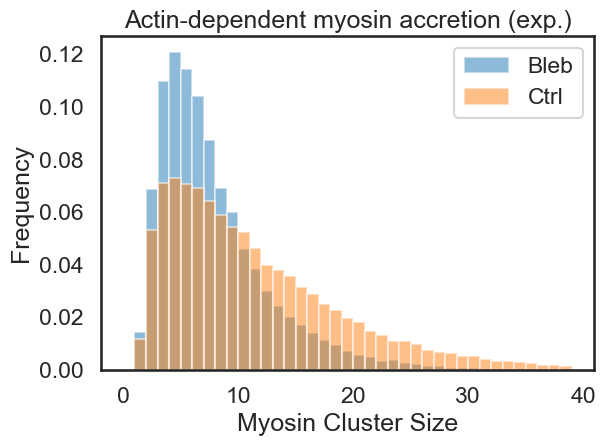

In [16]:
# Visualize experimental results
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(allPointDataBB['normInt'], bins = np.arange(40), alpha=0.5, density=True, label='Bleb')
plt.hist(allPointDataWT['normInt'], bins = np.arange(40), alpha=0.5, density = True, label='Ctrl')
plt.title('Actin-dependent myosin accretion (exp.)')
plt.legend()
plt.xlabel('Myosin Cluster Size')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.show()
plt.savefig('BB_ctrl.png', transparent = True)

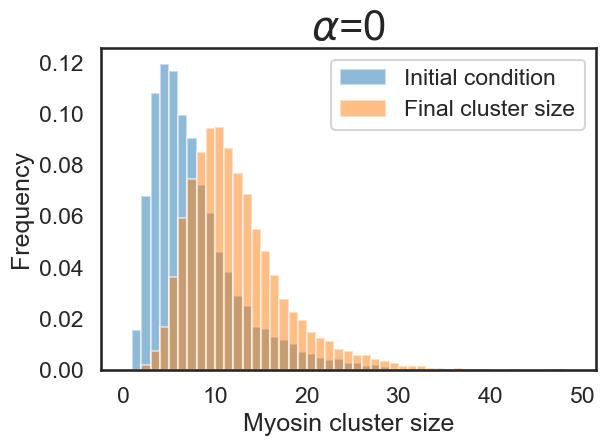

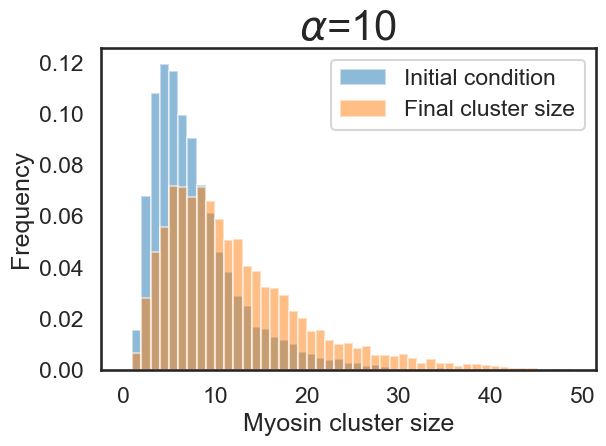

In [ ]:
numGrid = 10000
x, BB_cdf = ecdf(allPointDataBB['normInt'])
MyosinInit = randFromECDF(x, BB_cdf, numGrid)
numMyosin = int(np.sum(MyosinInit)*0.54)
myosinBiasVal = [0, 10]


co = sns.color_palette()
for ii in range(len(myosinBiasVal)):

    res = runSimulation(numGrid, numMyosin, MyosinInit, myosinBiasVal[ii])

    sns.set_style("white")
    sns.set_context("talk")
    plt.figure()
    plt.hist(MyosinInit, bins = np.arange(50), color = co[0], alpha=0.5, density = True, label = 'Initial condition')
    plt.hist(res, bins = np.arange(50), color = co[1], alpha = 0.5, density = True, label = 'Final cluster size')
    plt.xlabel("Myosin cluster size")
    plt.ylabel("Frequency")
    plt.title(r'$\alpha$='+str(myosinBiasVal[ii]), fontsize=30)
    plt.legend()
    plt.tight_layout()
    plt.savefig("myosinBinding_histogramComp_BB_ctrl_numMyosin_"+str(numMyosin)+"_acBias_0_myosinBias_"+str(myosinBiasVal[ii])+".png", dpi = 300, transparent = True)


    sns.set_style("white")
    sns.set_context("poster")
    plt.figure()
    plot_ecdf(allPointDataWT['normInt'], 'Experiment', '--', co[1])
    plot_ecdf(res, 'Simulation', '-', co[1])
    plt.title('Cumulative distribution')
    plt.xlabel("Myosin cluster size")
    plt.ylabel("Frequency")
    plt.legend()
    plt.xlim([0, 40])
    plt.tight_layout()
    plt.savefig('myosinBinding_ecdf_BB_ctrl_numGrid10000_numMyosin_'+str(numMyosin)+'_acBias_0_myoBias_'+str(myosinBiasVal[ii])+'.png', dpi = 300, transparent = True)

### Dependence of simulated results on choice of $\alpha$

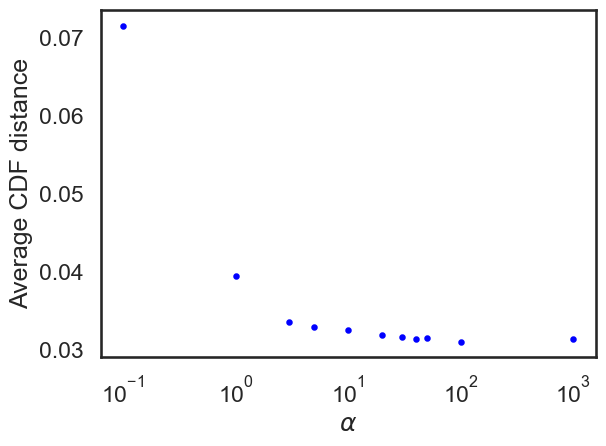

In [5]:
numGrid = 10000
x, BB_cdf = ecdf(allPointDataBB['normInt'])
MyosinInit = randFromECDF(x, BB_cdf, numGrid)
numMyosin = int(np.sum(MyosinInit)*0.54)
myosinBiasVal = [0.1, 1, 3, 5, 10, 20, 30, 40, 50, 100, 1000]


dist_arr = np.zeros((len(myosinBiasVal)))

for ii in range(len(myosinBiasVal)):
    res = runSimulation(numGrid, numMyosin, MyosinInit, myosinBiasVal[ii])
    #test = st.ks_2samp(res, allIntYoutB[allIntYoutB<=np.max(res)])

    dist_arr[ii] = cdf_dist(res, allPointDataWT['normInt'])

#co = sns.color_palette()
#sns.set_style("white")
#sns.set_context("talk")
#plt.figure()
#plot_ecdf(allIntWT, 'Experiment', '--', co[1])
#plot_ecdf(res, 'Simulation', '-', co[1])

sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.scatter(myosinBiasVal, dist_arr, 10, 'blue')
plt.xscale("log")
plt.xlabel(r"$\alpha$")
plt.ylabel("Average CDF distance")
plt.tight_layout()
plt.savefig("BlebtoWT_alpha scan.png", dpi = 300, transparent = True)

### Dependence of simulated results on the pool of myosin available for cluster growth

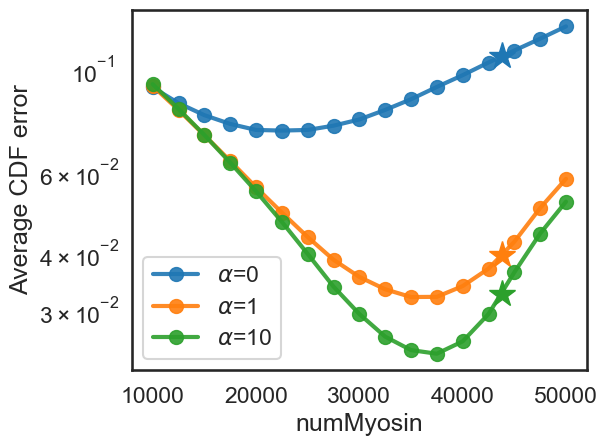

In [18]:
numGrid = 10000
x, BB_cdf = ecdf(allPointDataBB['normInt'])
MyosinInit = randFromECDF(x, BB_cdf, numGrid)
numMyosin = [10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000]
numMyosin_exp = int(np.sum(MyosinInit)*0.54)
myosinBiasVal = [0, 1, 10]

dist_arr = np.zeros((len(myosinBiasVal), len(numMyosin)))
sns.set_style("white")
sns.set_context("talk")
plt.figure()
co = sns.color_palette("tab10")

for ii in range(len(myosinBiasVal)):
    for jj in range(len(numMyosin)):
        res = runSimulation(numGrid, numMyosin[jj], MyosinInit, myosinBiasVal[ii])
        #test = st.ks_2samp(res, allIntYoutB[allIntYoutB<=np.max(res)])

        dist_arr[ii,jj] = cdf_dist(res, allPointDataWT['normInt'])
    plt.plot(numMyosin, dist_arr[ii,:], linewidth = 3, marker = '.', markersize = 20, alpha = .9, label = r"$\alpha$="+str(myosinBiasVal[ii]))
    
    res_exp = runSimulation(numGrid, numMyosin_exp, MyosinInit, myosinBiasVal[ii])
    dist_exp = cdf_dist(res_exp, allPointDataWT['normInt'])
    plt.plot(numMyosin_exp, dist_exp, marker = '*', markersize = 20, color = co[ii], alpha = 1, label = '')
    
plt.yscale('log')
plt.xlabel("numMyosin")
plt.ylabel("Average CDF error")
plt.legend()
plt.tight_layout()
plt.savefig("BBCtrl_numMyosin alpha scan.png", dpi = 300, transparent = True)
np.savetxt('BBCtrl_ParamScan_CDFerror.csv', dist_arr, delimiter=',')

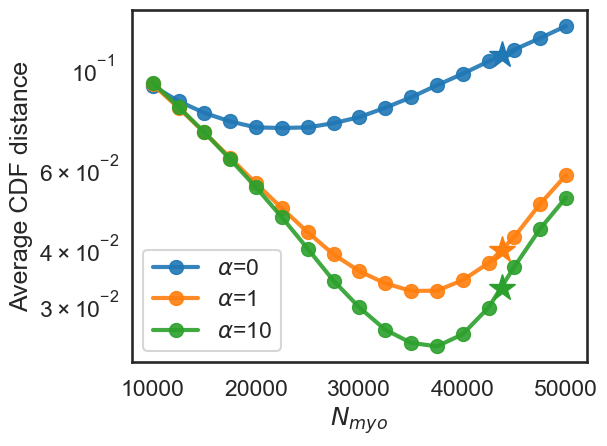

In [14]:
######## Use this if the simulated results have been saved!! ###########
### Plot CDF distance as a function of alpha and numMyosin from saved data
dist_arr = np.loadtxt('BBCtrl_ParamScan_CDFerror.csv', delimiter=',')
numGrid = 10000
x, BB_cdf = ecdf(allPointDataBB['normInt'])
MyosinInit = randFromECDF(x, BB_cdf, numGrid)
numMyosin = [10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000]
numMyosin_exp = int(np.sum(MyosinInit)*0.54)
myosinBiasVal = [0, 1, 10]


sns.set_style("white")
sns.set_context("talk")
plt.figure()
co = sns.color_palette("tab10")

for ii in range(len(myosinBiasVal)):
    plt.plot(numMyosin, dist_arr[ii,:], linewidth = 3, marker = '.', markersize = 20, alpha = .9, label = r"$\alpha$="+str(myosinBiasVal[ii]))
    
    res_exp = runSimulation(numGrid, numMyosin_exp, MyosinInit, myosinBiasVal[ii])
    dist_exp = cdf_dist(res_exp, allPointDataWT['normInt'])
    plt.plot(numMyosin_exp, dist_exp, marker = '*', markersize = 20, color = co[ii], alpha = 1, label = '')
    
plt.yscale('log')
plt.xlabel(r"$N_{myo}$")
plt.ylabel("Average CDF distance")
plt.legend()
plt.tight_layout()
plt.savefig("BBCtrl_numMyosin alpha scan.png", dpi = 300, transparent = True)
